**Part 3 - Mapping Closure in 2D for f_BZ using the IEM**

This notebook implements the interaction by exchange with the mean model (IEM) as introduced by (Dopazo, C. & O'Brien, E. 1974) and discussed by (Pope, S.B. 2010), in order to obtain a closure for the buoyancy equation

\begin{equation}
\frac{\partial B}{\partial t} + \left( \boldsymbol{U} \cdot \nabla \right) B = \alpha \nabla^2 B + Q(B),
\end{equation}

where $Q(B)$ is a source term/internal heat flux, when modelled using PDF methods. We model the time evolution of the PDF $f_{\boldsymbol{Y}}$ for $\boldsymbol{Y} = (B,Z)$.


*Evolution equation*

The joint pdf $f_{\boldsymbol{Y}}$ evolves according to 

\begin{equation}
    \frac{\partial f_{\boldsymbol{Y}} }{\partial t} = - \frac{\partial }{\partial z} \mathbb{E}_{\boldsymbol{Y}}[W] f_{\boldsymbol{Y}} - \frac{\partial }{\partial b} \left[ Q(B) f_{\boldsymbol{Y}} \right] - \alpha \frac{\partial^2 }{\partial b^2} \left( \mathbb{E}_{\boldsymbol{Y}}[ |\nabla B|^2] f_{\boldsymbol{Y}} \right) + \alpha \frac{\partial^2 }{\partial z^2} f_{\boldsymbol{Y}}.
\end{equation}

or

\begin{equation}
    \frac{\partial f_{\boldsymbol{Y}} }{\partial t} = - \frac{\partial }{\partial z} \mathbb{E}_{\boldsymbol{Y}}[W] f_{\boldsymbol{Y}} - \frac{\partial }{\partial b} \left[ Q(B) f_{\boldsymbol{Y}} \right] - \frac{\partial }{\partial b} \left( \mathbb{E}_{\boldsymbol{Y}}[ \alpha \nabla^2 B ] f_{\boldsymbol{Y}} \right).
\end{equation}


In this equation $\mathbb{E}_{\boldsymbol{Y}}[W]$ is responsible for meso-scale mixing by moving $f_{\boldsymbol{Y}}$ in real space and $\mathbb{E}_{\boldsymbol{Y}}[\alpha  |\nabla B|^2 ]$ ( or $\mathbb{E}_{\boldsymbol{Y}}[\alpha \nabla^2 B ]$) is responsible for micro-scale molecular mixing locally in composition space. Both terms are unknown and must be modelled.

*Velocity closure*

For the vertical velocity we will use a gradient diffusion model
\begin{equation}
\mathbb{E}_{\boldsymbol{Y}}[W] f_{BZ} = - \alpha_T \frac{\partial f_{BZ}}{\partial z}, 
\end{equation}
where the turbulent diffusivity $\alpha_T(z,t)$ which must be modelled should depend on ??.

*Molecular mixing closure*

For the conditional diffusion term we will employ the IEM model. However, to expose the contribution of the forcing at the top and bottom boundaries we write the molecular diffusion term in terms of its horizontal $\nabla_H$ and vertical $\nabla_Z$ components as 

\begin{equation}
\mathbb{E}_{\boldsymbol{Y}}[ \alpha |\nabla B|^2 ] = \mathbb{E}_{\boldsymbol{Y}}[ \alpha |\nabla_H B|^2 ]+ \mathbb{E}_{\boldsymbol{Y}}[ \alpha |\nabla B_Z|^2].
\end{equation}

Assuming statistically homogeneous horizontal slices, we apply the IEM model to horizontal slices

\begin{equation}
  \mathbb{E}_{\boldsymbol{Y}}[ \alpha |\nabla_H B|^2 ] f_{\boldsymbol{Y}} = -\frac{\alpha}{\tau_{B}(t)} \int \left( b - \mathbb{E}_Z[B] \right) f_{\boldsymbol{Y}} \, db,
\end{equation}

where $\tau_B(t)$ defines a characteristic time-scale of the buoyancy fluctuations. For the vertical gradient however we need a further assumption. Opting to relate the horizontal and vertical gradients via the parameter $\lambda(z)$ which characterises the ratio of the vertical and horizontal Taylor microscales we can write

\begin{equation}
  \mathbb{E}_{\boldsymbol{Y}}[ \alpha |\nabla B|^2 ] f_{\boldsymbol{Y}} = -\frac{\alpha(1 + \lambda)}{\tau_{B}(t)} \int \left( b - \mathbb{E}_Z[B] \right) f_{\boldsymbol{Y}} \, db.
\end{equation}

*Closed evolution equation*

Substituting the closures for the unknown terms we obtain

\begin{equation}
    \frac{\partial f_{\boldsymbol{Y}} }{\partial t} = - \frac{\partial }{\partial b} \left[ Q(B) f_{\boldsymbol{Y}} \right] + \frac{\alpha( 1 + \lambda(z))}{\tau_{B}(t)} \frac{\partial }{\partial b} \left[ \left( b - \mathbb{E}_Z[B] \right) f_{\boldsymbol{Y}} \right] +  \frac{\partial }{\partial z} \left( ( \alpha + \alpha_T(z,t) )  \frac{\partial  f_{\boldsymbol{Y}} }{\partial z} \right).
\end{equation}

which is an integro-differential equation, as

\begin{equation}
\mathbb{E}_Z[B] = \int b f_{B|Z}(b|z;t) db = \int b \frac{f_{BZ}(b|z;t)}{f_Z(z)} db.
\end{equation}

depends on the PDF at each time-instant. Subject to specifying $\lambda, \tau, \alpha_T$ and suitable boundary conditions this equation is closed and can be solved numerically. Below we implement this equation using finite differences by specifying $f_{B}(b;z=0,t)$ and $f_{B}(b;z=1,t)$ as a normal distribution with mean $\mu_0 = 1, \mu_1 = -1$ respectively and variance $\Sigma = 1/2$ in both cases. 

**Setup**

We first import the required libraries to implement this model.

In [162]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid 
from scipy.special import erf

from   scipy import sparse
import scipy.sparse.linalg as sla

We then define a computation grid for $f_{B}(b,z;t)$ in terms of $b,z$. When defining the $f^n_B(b,z) = f_B(b,z,t=t_n)$ we use 2 dimensional arrays where axis 0 is $b$ and the axis 1 is $z$.

In [173]:
# Boundary conditions
bc_b = 'Neumann'
bc_z = 'Neumann'

# Numerical resolution
N_b = 32
N_z = 32

# Domain
b = np.linspace(-2, 2, N_b)
z = np.linspace(0, 1, N_z) 

# Time-scale
𝜏 = 1

# Ratio of Taylor-microscales
λ = 1

*Differential operators*

To define the differential operators in the equations right hand sides we first define the gradient and Laplacian operators:

In [174]:
# Define the gradient & Laplacian operators
def grad(x):
  """Gradient operator ∂/∂x"""
  N = len(x)
  dx= x[1] - x[0] 
  D = np.zeros((N,N))
  for i in range(N):
    if i < N-1:
      D[i,i+1] = 1
    if i > 0:
      D[i,i-1] =-1
  return D/(2*dx)

def laplacian(x, bcs = 'Dirichlet'):
  """Laplacian ∂^2/∂x^2"""
  
  N = len(x)
  dx= x[1] - x[0] 

  L = np.zeros((N,N))
  for i in range(N):

    L[i,i] = -2.
    if i ==N-1:
      if bcs == 'Dirichlet':
        L[i,i-1] = 1
      elif bcs == 'Neumann':
        L[i,i-1] = 2
    elif i == 0:
      if bcs == 'Dirichlet':
        L[i,i+1] = 1
      elif bcs == 'Neumann':
        L[i,i+1] = 2
    else:
      L[i,i-1] = 1
      L[i,i+1] = 1

  return L/(dx**2)

def sparse_grad(x):
  """Gradient operator ∂/∂x"""
  N = len(x)
  dx= x[1] - x[0] 

  Akp1 =      np.ones(N-1)
  Akm1 = -1.0*np.ones(N-1)

  return sparse.diags( [Akm1,Akp1], [-1,1] )/(2*dx)

def sparse_laplacian(x, bcs = 'Dirichlet'):
  """Laplacian ∂^2/∂x^2"""
  
  N = len(x)
  dx= x[1] - x[0] 

  Akp1 =      np.ones(N-1);
  Ak0  = -2.0*np.ones(N  );
  Akm1 =      np.ones(N-1);
  
  # Boundary Condiitions 
  if bcs == 'Neumann':
      Akp1[0 ] = 2.0; # Use f_1     = f_-1    @ f_0
      Akm1[-1] = 2.0; # Use f_{N+1} = f_{N-1} @ f_N
  elif bcs == 'Dirichlet':
      Akp1[0]  = 0.
      Ak0[0]   = 0.; Ak0[-1] =0.
      Akm1[-1] = 0.

  return sparse.diags( [Akm1,Ak0,Akp1], [-1,0,1] )/(dx**2)

def test_derivatives():
  """Check the derivatives are correctly implemented"""
  
  x = np.linspace(0, 2*np.pi, 256)
  
  D = grad(x)
  error_D = ( np.cos(x)[1:-1] - D.dot(np.sin(x))[1:-1])**2
  assert np.trapz(y=error_D,x=x[1:-1]) < 1e-07

  L = laplacian(x)
  error_L = (-np.sin(x)[1:-1] - L.dot(np.sin(x))[1:-1])**2
  assert np.trapz(y=error_L,x=x[1:-1]) < 1e-07

  return None

test_derivatives()

Finally we specify the boundary conditions for the joint pdf as
\begin{equation}
f_{B|Z=z_i} = \frac{1}{\Sigma \sqrt{2 \pi} } \exp\left( -\frac{1}{2} \left( \frac{b - \mu_i}{\Sigma} \right)^2 \right)
\end{equation}
with $\mu_0 = 1$ and the bottom boundary ($z=0$) and $\mu_0=-1$ and the top boundary ($z=1$).

In [175]:
μ_0 = [0.1,0.9]
Σ_0 = [.25,0.25]
A_0 = [0.5,0.5]

μ_1 = [-1]
Σ_1 = [.25]
A_1 = [1]

def BC_PDF(b, z):
    
    if   z == 0:
        f = 0*b
        for μ_i,Σ_i,c_i in zip(μ_0,Σ_0,A_0):
            f += c_i*np.exp(-.5*( (b - μ_i)/Σ_i)**2 )/(Σ_i*np.sqrt(2*np.pi))
        return f
    elif z == 1:
        f = 0*b
        for μ_i,Σ_i,c_i in zip(μ_1,Σ_1,A_1):
            f += c_i*np.exp(-.5*( (b - μ_i)/Σ_i)**2 )/(Σ_i*np.sqrt(2*np.pi))
        return f
    else:
        return None

def BC_CDF(b, z):
    
    if   z == 0:
        return .5*( 1 + erf( (b - μ_0)/(np.sqrt(2)*Σ) ) )
    elif z == 1:
        return .5*( 1 + erf( (b - μ_1)/(np.sqrt(2)*Σ) ) )
    else:
        return None

Using these operators we construct implicit and explicit time stepping schemes

In [176]:
def operators_EXP(b, z):

  I_b = np.eye(len(b))
  I_z = np.eye(len(z)) 

  D_b = np.kron(grad(b),I_z)
  D_z = np.kron(I_b,grad(z))

  L_b = np.kron(laplacian(b,bcs=bc_b),I_z)
  L_z = np.kron(I_b,laplacian(z,bcs=bc_z)) 

  return L_b, L_z, D_b, D_z

def solve_EXP(f, b, z, Δt, L_b, L_z, D_b, D_z, α_T=1, α=1, λ = 10, τ_B=1):

  # a) Compute diffusion from Z
  RHS_z  = α*L_z@f
  #RHS_z = D_z@( α_T*(D_z@f) )

  # b) Compute the expectation 
  db = b[1] - b[0]
  Φ = np.kron(b,np.ones(N_z))
  
  E_B = np.sum( (Φ*f).reshape((N_b,N_z)), axis=0)*db
  E_B = np.kron(np.ones(N_b), E_B) 
  
  RHS_b = α*((1 + λ)/τ_B)*D_b@( (Φ - E_B)*f ) + L_b@f
  
  # c) Update the mapping 
  return f + Δt*(RHS_b + RHS_z)

We then write helper functions to recover the density from the mapping and to enforce the boundary conditions.

In [177]:
def enforce_bc(f,b,z):

  f = f.reshape((len(b),len(z)))
  f[:, 0] = BC_PDF(b,z=0)
  f[:,-1] = BC_PDF(b,z=1)
  return f.flatten()

def solver(f, b, z, T, Δt):

  f_frames = []
  f_frames.append(f)

  L_b, L_z, D_b, D_z = operators_EXP(b, z) 

  # Loop over all time instants
  for n,t in enumerate(T):
  
    # 0) Plot the system out
    if n%(len(T)//10) == 0:
      print('t = %3.3f \n' % t)
      
      fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, layout='constrained')
      ax1.set_title(r'$f$')
      cf = ax1.pcolormesh(b,z,f.reshape((len(b),len(z))).T, cmap='Reds')#, norm='log')
      fig.colorbar(cf, ax=ax1)
      ax1.set_xlabel('$b$')
      ax1.set_ylabel('$z$')

      db = b[1] - b[0]
      Φ = np.kron(b,np.ones(N_z))
      E_B = np.sum( (Φ*f).reshape((N_b,N_z)), axis=0)*db

      ax2.set_title(r'$\mathbb{E}_Z[B]$')
      ax2.set_ylabel('$z$')
      ax2.set_xlabel('$b$')
      ax2.plot(E_B, z)
      plt.show()

    # 1) Update the mapping
    f = enforce_bc(f, b, z)
    f = solve_EXP(f, b, z, Δt, L_b, L_z, D_b, D_z)

    # 2) Grab the system state
    f_frames.append(f)

  return None

Finally we specify a time interval, initial conditions and time-step the system

Δt =  0.0001001001001001001
t = 0.000 



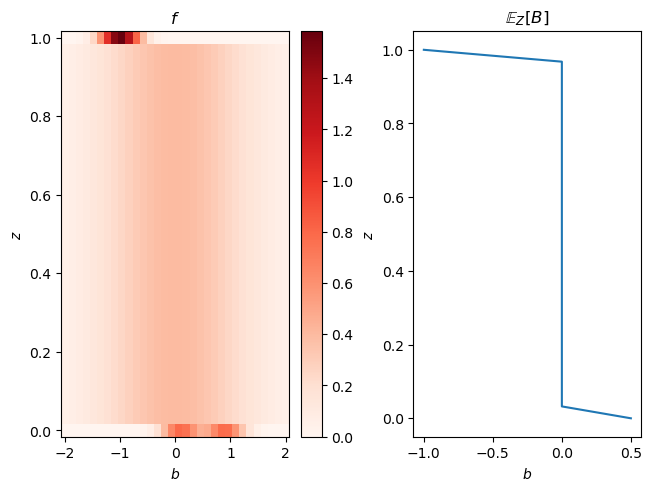

t = 0.010 



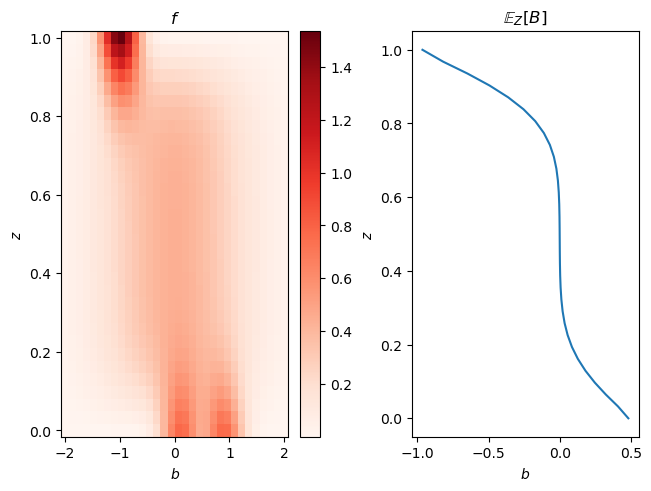

t = 0.020 



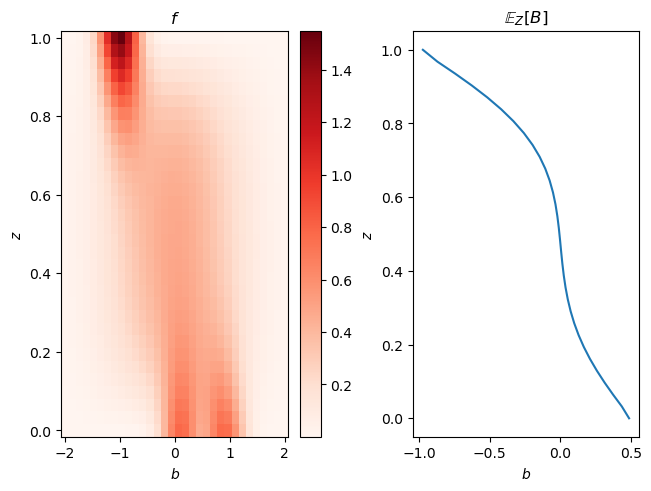

t = 0.030 



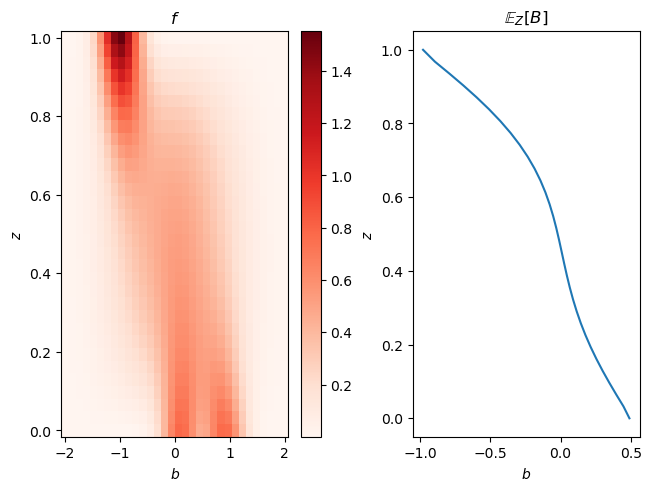

t = 0.040 



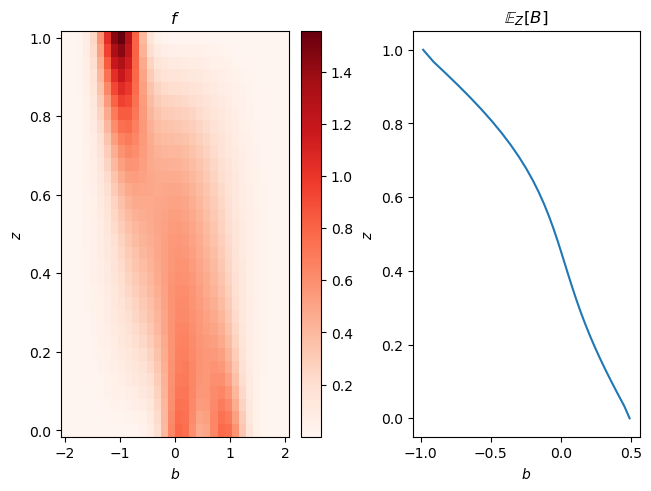

t = 0.050 



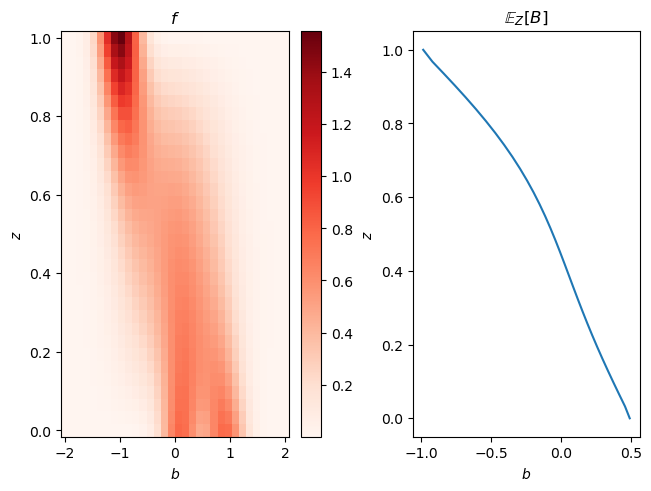

t = 0.060 



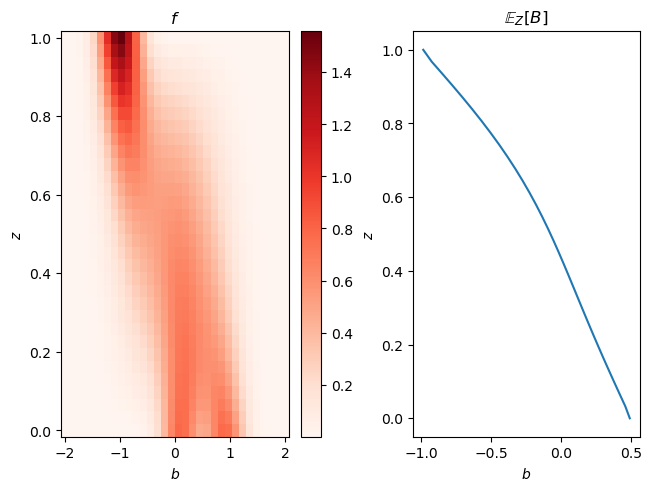

t = 0.070 



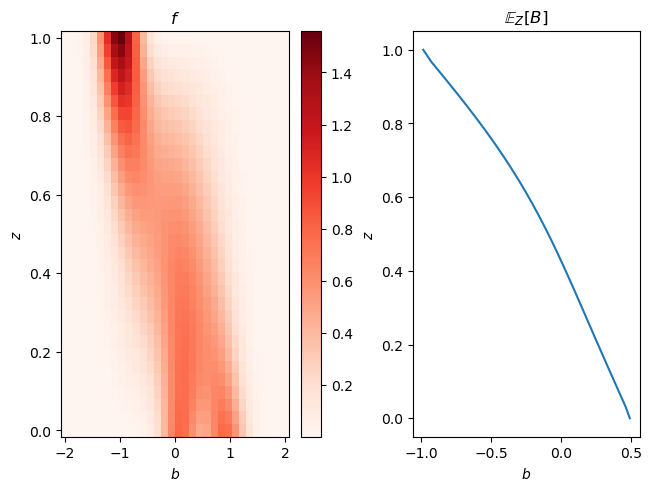

t = 0.080 



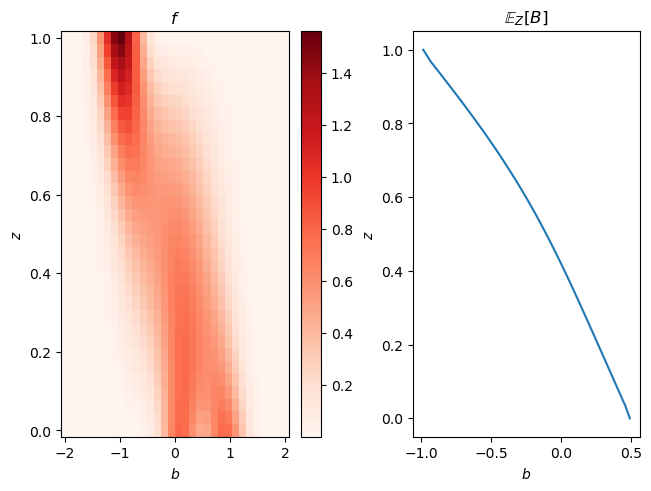

t = 0.090 



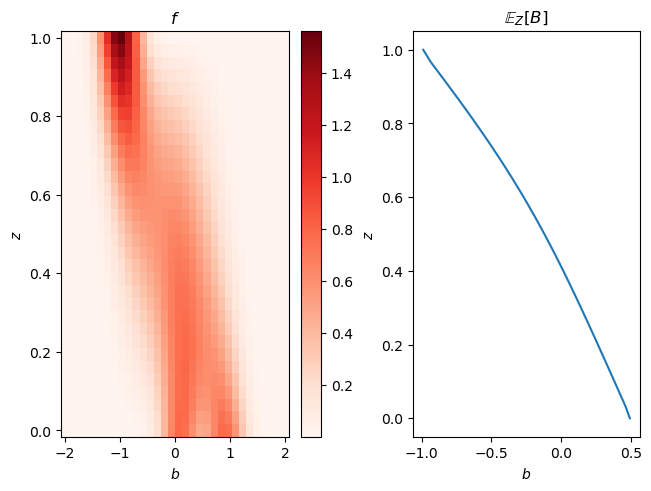

In [179]:
N_T = 10**3
T, Δt = np.linspace(0,.1,N_T,retstep=True)
print('Δt = ',Δt)

# Initial conditions for f shape b, z
f = np.zeros((len(b),len(z)))
for i,z_i in enumerate(z):
    if i == 0:
        f[:,i] = BC_PDF(b,z=0)
    elif i == len(z)-1:
        f[:,i] = BC_PDF(b,z=1)
    else:
        f[:,i] = g(b)

# Flatten the inputs and pass them to the solver and check with reshape
f = f.flatten()

solver(f, b, z, T, Δt)